# LOAD USEFUL LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, save, load
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from sklearn.metrics import precision_score, recall_score, fbeta_score
from tabulate import tabulate
import copy
import torch.nn.init as init
from sklearn.linear_model import LinearRegression


#Adam optimizer: https://www.linkedin.com/pulse/getting-know-adam-optimization-comprehensive-guide-kiran-kumar/

# DEVICE CONFIGURATION

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# DEFINE GLOBAL VARIABLES

In [ ]:
#NETWORKS SIZES
Input_Size_1= 48
Hidden_Size_1=40
Output_Size_1=48
Input_Size_2= 48


# pre-training and hyperparamentes
learning_rate = 0.4
n_epochs_pre = 60
momentum=0.5
temperature=1.0
patterns_number_pre=80


#GRAPHIC OF PRETRAINING
epoch_list = list(range(1, n_epochs_pre + 1))
epoch_1_order= np.zeros(n_epochs_pre)
epoch_2_order= np.zeros(n_epochs_pre)


colors = [
    'b', 'g', 'r', 'c', 'm', 'y', 'k',
    '#FF5733', '#33FF57', '#5733FF', '#33FFFF', '#FF33FF', '#FFFF33',
    '#990000', '#009900', '#000099', '#999900', '#990099', '#009999',
    '#CC0000', '#00CC00', '#0000CC', '#CCCC00', '#CC00CC', '#00CCCC',
    '#FF6666', '#66FF66', '#6666FF', '#FFFF66', '#FF66FF', '#66FFFF'
]

# CUSTOMED WINNER TAKES ALL MECHANISM

In [ ]:
def winner_takes_all(decoded):
    winner_takes_all = decoded.clone()
    batch_size, num_classes = decoded.size()

    # Ensure each data point has 48 elements
    if num_classes != 48:
        raise ValueError("Each data point must have 48 elements")

    # Process each batch
    for i in range(batch_size):
        for j in range(0, num_classes, 6):
            # Find the index and value of the maximum in each 6-element section
            max_val, max_idx = torch.max(decoded[i, j:j+6], 0)

            # Sum the values of the other 5 elements
            sum_of_others = torch.sum(decoded[i, j:j+6]) - max_val

            # Add the sum of other values to the maximum value
            enhanced_max_val = max_val + sum_of_others

            # Set the maximum value to the enhanced value
            winner_takes_all[i, j + max_idx] = enhanced_max_val * batch_size / 10

    return winner_takes_all



# FIRST ORDER NETWORK ARCHITECTURE DEFINITION

In [ ]:
class FirstOrderNetwork(nn.Module):

    def __init__(self):
        super(FirstOrderNetwork, self).__init__()

        # Encoder Layer
        self.enc_linear = nn.Linear(48, 40)  # 48 -> 40

        # Decoder Layer
        self.dec_linear = nn.Linear(40, 48)  # 40 -> 48

        self.temperature = 1.0

        #activation functions
        self.relu= torch.relu
        self.gelu= torch.nn.GELU()
        self.sigmoid = torch.sigmoid
        self.softmax = torch.nn.Softmax(dim=1)  # Softmax activation - winner takes all

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize weights uniformly between -1.0 and 1.0
        init.uniform_(self.enc_linear.weight, -1.0, 1.0)
        init.uniform_(self.dec_linear.weight, -1.0, 1.0)

    def forward(self, x):
        # Encoder
        encoded = self.gelu(self.enc_linear(x)/self.temperature)

        # Decoder
        final_output = self.softmax(self.dec_linear(encoded))  # Using softmax to normalize

        # Apply winner takes all function
        final_output = winner_takes_all(final_output)

        return final_output



# SECOND ORDER NETWORK ARCHITECTURE DEFINITION

In [ ]:
class SecondOrderNetwork(nn.Module):
    def __init__(self):
        super(SecondOrderNetwork, self).__init__()

        # The input is the difference of two 48-unit vectors, so input size is still 48
        self.input_layer = nn.Linear(48, 48)
        self.output_layer = nn.Linear(48, 48)
        self.comparison_layer = nn.Linear(48, 48)

        # These units are connected to one unit representing high and low wagers
        self.wager = nn.Linear(48, 1)

        # Activation functions
        self.relu = torch.relu
        self.gelu= torch.nn.GELU()
        self.softmax = torch.nn.Softmax(dim=1)  # Softmax activation - winner takes all
        self.sigmoid=torch.sigmoid
        self.tanh=torch.tanh

        # Initialize weights
        self._init_weights()

    def _init_weights(self):

        # Wager layer weights can be initialized uniformly
        init.uniform_(self.input_layer.weight, -1.0, -1.0)
        init.uniform_(self.output_layer.weight, 1.0, 1.0)

        init.uniform_(self.comparison_layer.weight, 0.0, 0.1)
        init.uniform_(self.wager.weight, 0.0, 0.1)

    def forward(self, first_order_input, first_order_output):

        init.uniform_(self.input_layer.weight, -1.0, -1.0)
        init.uniform_(self.output_layer.weight, 1.0, 1.0)

        # Create a comparison matrix by subtracting the output from the input
        matrix_input= self.softmax(self.input_layer(first_order_input))
        matrix_output= self.softmax(self.output_layer(first_order_output))

        comparison_matrix = matrix_input - matrix_output

        batch_size, num_classes = comparison_matrix.size()

        comparison_out = self.gelu(self.comparison_layer(comparison_matrix))

        wager = self.sigmoid(self.wager(comparison_out)) * batch_size /10

        return wager


# FUNCTIONS THAT CREATES RANDOM , GRAMMAR A, AND GRAMMAR B WORDS



In [ ]:
#GRAMMAR A AND GRAMMAR B WORDS ARE BUILD BASED ON THE ARCHITECTURE SHOWN ON FIGURE 5.1, FROM THE PAPER "Five Transfer of implicit knowledge across domains: How
#implicit and how abstract?" (DIENES, 1997)

def Generate_Word_Random():
    grammar_word = ""
    number_letters = random.randint(3, 8)
    allowed_letters = ["x", "v", "m", "t", "r"]  # Letters from Grammar A and B
    while len(grammar_word) < number_letters:
        current_letter = random.choice(allowed_letters)
        grammar_word += current_letter
    return grammar_word



def Generate_Grammar_A():
  grammar_A_word=""
  number_letters=random.randint(3,8)
  position=1
  i=0
  while len(grammar_A_word) < number_letters:

    current_path = random.randint(1, 2)

    (grammar_A_word := grammar_A_word + "x", position := 2) if (position, current_path) == (1, 1) else (grammar_A_word := grammar_A_word + "v", position := 3) if (position, current_path) == (1, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_A_word)==number_letters:
      break
    (grammar_A_word := grammar_A_word + "m", position := 2) if (position, current_path) == (2, 1) else (grammar_A_word := grammar_A_word + "x", position := 4) if (position, current_path) == (2, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_A_word)==number_letters:
      break
    (grammar_A_word := grammar_A_word + "t", position := 3) if (position, current_path) == (3, 1) else (grammar_A_word := grammar_A_word + "v", position := 5) if (position, current_path) == (3, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_A_word)==number_letters:
      break
    (grammar_A_word := grammar_A_word + "t", position := 4) if (position, current_path) == (4, 1) else (grammar_A_word := grammar_A_word + "m", position := 6) if (position, current_path) == (4, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_A_word)==number_letters:
      break
    (grammar_A_word := grammar_A_word + "r", position := 3) if (position, current_path) == (5, 1) else (grammar_A_word := grammar_A_word + "m", position := 6) if (position, current_path) == (5, 2) else None

    if position==6:
      break
  return grammar_A_word


def Generate_Grammar_B():
  grammar_B_word=""
  number_letters=random.randint(3,8)
  position=1
  i=0
  while len(grammar_B_word) < number_letters:

    current_path = random.randint(1, 2)

    (grammar_B_word := grammar_B_word + "x", position := 2) if (position, current_path) == (1, 1) else (grammar_B_word := grammar_B_word + "v", position := 3) if (position, current_path) == (1, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_B_word)==number_letters:
      break
    (grammar_B_word := grammar_B_word + "x", position := 5) if (position, current_path) == (2, 1) else (grammar_B_word := grammar_B_word + "m", position := 3) if (position, current_path) == (2, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_B_word)==number_letters:
      break
    (grammar_B_word := grammar_B_word + "v", position := 4) if (position, current_path) == (3, 1) else (grammar_B_word := grammar_B_word + "t", position := 5) if (position, current_path) == (3, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_B_word)==number_letters:
      break
    (grammar_B_word := grammar_B_word + "t", position := 4) if (position, current_path) == (4, 1) else (grammar_B_word := grammar_B_word + "r", position := 2) if (position, current_path) == (4, 2) else None

    current_path = random.randint(1, 2)
    if len(grammar_B_word)==number_letters:
      break

    if position==5:
       if current_path==1:
        grammar_B_word+="r"
       elif len(grammar_B_word)>2:
          break

  return grammar_B_word




#FUNCTION THAT ENCODES THE WORD TO GIVE TO THE NEURAL NETWORK



In [ ]:
# each letter encoded as a unique one-hot vector. Since there are 5 possible letters, each letter could be represented as a 5-dimensional vector (e.g., 'a' = [1, 0, 0, 0, 0], 'b' = [0, 1, 0, 0, 0], etc.).
#A string with a maximum of 8 letters would then be a 40-dimensional vector (8 letters x 5 dimensions per letter).

def encode_word(word):
    # Define the mapping
    mapping = {"x": [1, 0, 0, 0, 0],
               "v": [0, 1, 0, 0, 0],
               "m": [0, 0, 1, 0, 0],
               "t": [0, 0, 0, 1, 0],
               "r": [0, 0, 0, 0, 1]}

    # Initialize the output array with zeros
    encoded = [0] * 48  # 48 elements, all zeros

    # Encode each letter and place it in the output array
    for i, letter in enumerate(word):
        encoded[i*5:(i+1)*5] = mapping[letter]

    return encoded



# Decode to the original word
def decode_word(encoded):
    # Define the reverse mapping
    reverse_mapping = {(1, 0, 0, 0, 0): "x",
                       (0, 1, 0, 0, 0): "v",
                       (0, 0, 1, 0, 0): "m",
                       (0, 0, 0, 1, 0): "t",
                       (0, 0, 0, 0, 1): "r"}

    word = ""
    # Process each 5-bit chunk in the 48-element array
    for i in range(0, 48, 5):
        chunk = tuple(encoded[i:i+5])
        if chunk in reverse_mapping:
            word += reverse_mapping[chunk]

    return word

# FUNCTION THAT MAKES ARRAYS OF WORDS (for pre-training, training, testing)



In [ ]:
def Array_Words(grammar_type , number):
  list_words=[]
  while len(list_words) < number:

    if grammar_type==1:
      generated= Generate_Word_Random()
    if grammar_type==2:
      generated= Generate_Grammar_A()
    if grammar_type==3:
      generated= Generate_Grammar_B()

    generated_encoded= encode_word(generated)
    list_words.append(generated_encoded)

  list_words=torch.Tensor(list_words)
  return list_words

# FUNCTION THAT RETURNS SECOND ORDER TARGETS


In [ ]:
def target_second(input, output):
    if input.shape != output.shape:
        raise ValueError("Input and output must have the same shape")

    num_rows, num_cols = input.shape
    result = torch.zeros(num_rows)

    for i in range(num_rows):
        # Count the number of 1s in the input row
        input_indexes = (input[i] == 1).nonzero(as_tuple=True)[0]
        num_ones = input_indexes.size(0)

        # Get the indexes of the top x values in the output row
        _, output_indexes = torch.topk(output[i], num_ones)

        #print("target, input top: ",input_indexes, " target, output top: ", output_indexes)
        # Compare and set the result
        if set(input_indexes.tolist()) == set(output_indexes.tolist()):
            result[i] = 1.0

    return result

#ASSIGNMENT OF FIRST AND SECOND ORDER NETWORK, AND DEFINITION OF CRITERIONS


In [ ]:
first_order_network = FirstOrderNetwork().to(device)
second_order_network = SecondOrderNetwork().to(device)

criterion_1 = nn.MSELoss()
criterion_2 = nn.BCEWithLogitsLoss() #Binary Cross-Entropy Loss: especially used in classification tasks
#criterion_2 = nn.MSELoss() #Binary Cross-Entropy Loss: especially used in classification tasks
#criterion_2 = nn.BCELoss() #Binary Cross-Entropy Loss: especially used in classification tasks


# Using Adam optimizer
optimizer_1 = optim.Adam(first_order_network.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)
optimizer_2 = optim.Adam(second_order_network.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)


initial_first_order_weights = copy.deepcopy(first_order_network.state_dict())  # Store initial weights

#PRECISION


In [ ]:
def calculate_precision(patterns_tensor, output_first_order):
    # Initialize counters for true positives (tp) and false positives (fp)
    tp_input = 0
    fp_input = 0

    for i in range(len(patterns_tensor)):

        #represent missing 1 character
        threshold = 1/patterns_tensor[i].sum()

        if abs(patterns_tensor[i].sum() - output_first_order[i].sum()) <= threshold * patterns_tensor[i].sum():
            tp_input += 1
        else:
            fp_input += 1

    precision_input = tp_input / (tp_input + fp_input)

    return precision_input

# PRE TRAINING LOOP

In [ ]:
precision= np.zeros((n_epochs_pre))

for epoch in range(n_epochs_pre):

    patterns_tensor = Array_Words(1, patterns_number_pre)
    output_first_order = first_order_network(patterns_tensor)
    output_second_order = second_order_network(patterns_tensor, output_first_order).squeeze()
    order_2_tensor_without = target_second(patterns_tensor, output_first_order)

    loss_2 = criterion_2(output_second_order, order_2_tensor_without).requires_grad_()
    loss_2.backward(retain_graph=True)
    optimizer_2.step()
    optimizer_2.zero_grad()

    loss_1 = criterion_1(output_first_order, patterns_tensor).requires_grad_()
    loss_1.backward(retain_graph=True)
    optimizer_1.step()
    optimizer_1.zero_grad()

    epoch_1_order[epoch] = loss_1.detach().item()
    epoch_2_order[epoch] = loss_2.detach().item()

    precision[epoch] = calculate_precision(patterns_tensor, output_first_order)

first_order_network.load_state_dict(initial_first_order_weights)

<All keys matched successfully>

# LOSS PLOT

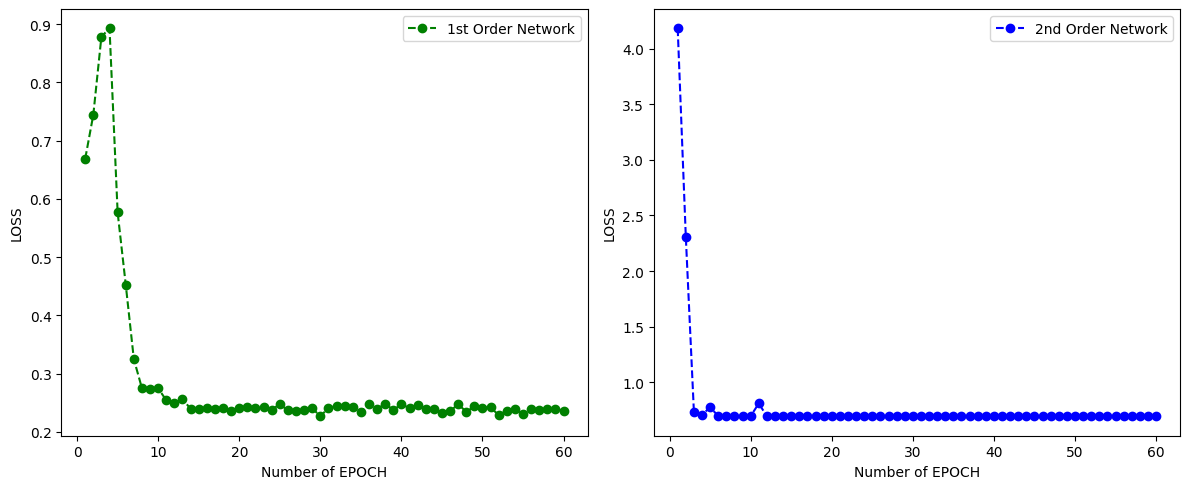

In [ ]:
# Set up the plot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figure size as needed

# First graph for 1st Order Network
ax1.plot(epoch_list, epoch_1_order, linestyle='--', marker='o', color='g')
ax1.legend(['1st Order Network'])
ax1.set_xlabel('Number of EPOCH')
ax1.set_ylabel('LOSS')

# Second graph for 2nd Order Network
ax2.plot(epoch_list, epoch_2_order, linestyle='--', marker='o', color='b')
ax2.legend(['2nd Order Network'])
ax2.set_xlabel('Number of EPOCH')
ax2.set_ylabel('LOSS')

# Display the plots side by side
plt.tight_layout()
plt.show()

# Function that performs linear regression

In [ ]:
def perform_linear_regression(epoch_list, precision):
    # Perform linear regression
    X = np.array(epoch_list).reshape(-1, 1)
    y = np.array(precision)
    reg = LinearRegression().fit(X, y)
    y_pred = reg.predict(X)

    return y_pred

# PRECISION   - RANDOM PATTERNS

---





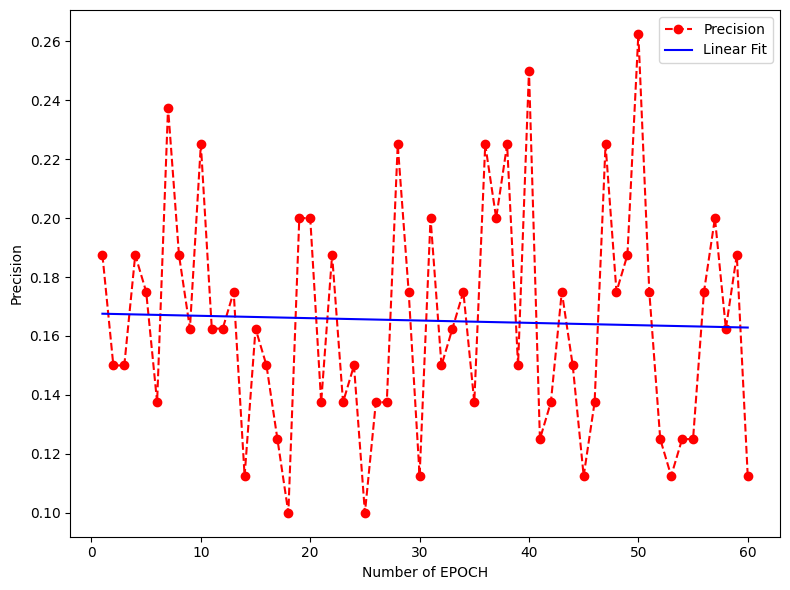

In [ ]:


fig, ax = plt.subplots(1, 1, figsize=(8, 6))  # Adjust the figure size as needed

# Plot precision
ax.plot(epoch_list, precision, linestyle='--', marker='o', color='r', label='Precision')
ax.set_xlabel('Number of EPOCH')
ax.set_ylabel('Precision')

# Perform linear regression
y_pred = perform_linear_regression(epoch_list, precision)
# Plot the linear function
ax.plot(epoch_list, y_pred, linestyle='-', color='b', label='Linear Fit')

# Display the legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


# MODELS SAVING

In [ ]:
PATH = './cnn1.pth'
PATH_2 = './cnn2.pth'

torch.save(first_order_network.state_dict(), PATH)
torch.save(second_order_network.state_dict(), PATH_2)


# MODEL LOADING FOR TRAINING AND SET UP OF THE 30 NETWORKS

In [ ]:
num_networks=30
networks = []
for i in range(num_networks):
    loaded_model_trai = FirstOrderNetwork()
    loaded_model_2_trai = SecondOrderNetwork()

    loaded_model_trai.load_state_dict(torch.load(PATH))
    loaded_model_2_trai.load_state_dict(torch.load(PATH_2))

    loaded_model_trai.to(device)
    loaded_model_2_trai.to(device)

    criterion_1 = nn.MSELoss()
    criterion_2 =   nn.BCEWithLogitsLoss()

    optimizer_1 = optim.Adam(loaded_model_trai.parameters(),  lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)
    optimizer_2 = optim.Adam(loaded_model_2_trai.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)

    networks.append([loaded_model_trai, loaded_model_2_trai , criterion_1 , criterion_2 , optimizer_1 , optimizer_2])


#AVERAGE, MAX, MIN FUNCTIONS FOR PLOTS

In [ ]:
def calculate_average(network_data, start_network, end_network):
    num_epochs = len(network_data[0])
    average = [0] * num_epochs
    num_networks = end_network - start_network
    for epoch in range(num_epochs):
        sum_loss = sum(network_data[i][epoch] for i in range(start_network, end_network))
        average[epoch] = sum_loss / num_networks
    return average

def calculate_max(network_data, start_network, end_network):
    num_epochs = len(network_data[0])
    maximum = [0] * num_epochs
    for epoch in range(num_epochs):
        maximum[epoch] = max(network_data[i][epoch] for i in range(start_network, end_network))
    return maximum

def calculate_min(network_data, start_network, end_network):
    num_epochs = len(network_data[0])
    minimum = [float('inf')] * num_epochs
    for epoch in range(num_epochs):
        minimum[epoch] = min(network_data[i][epoch] for i in range(start_network, end_network))
    return minimum

# TRAINING - HIGH CONSCIOUSNESS






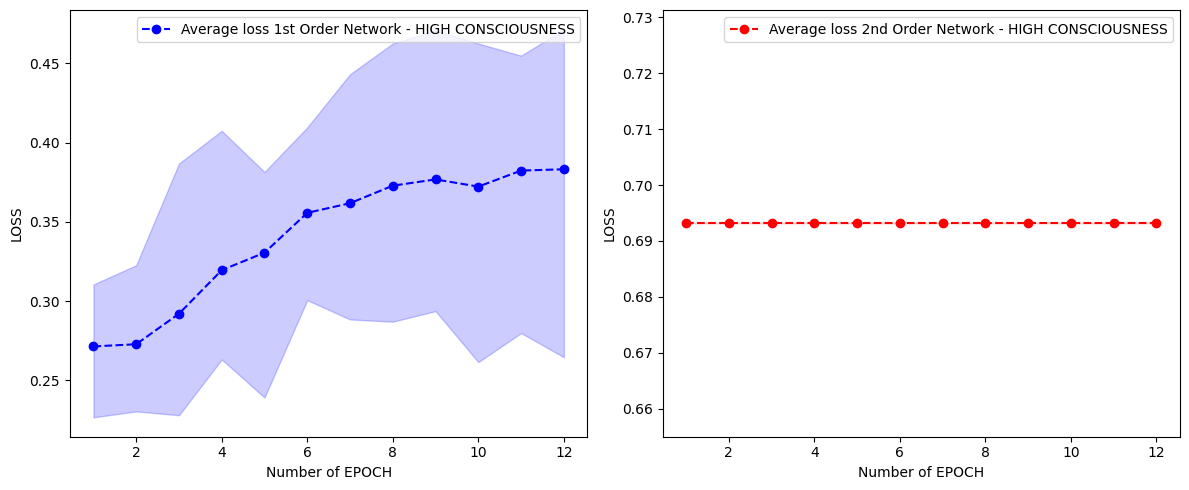

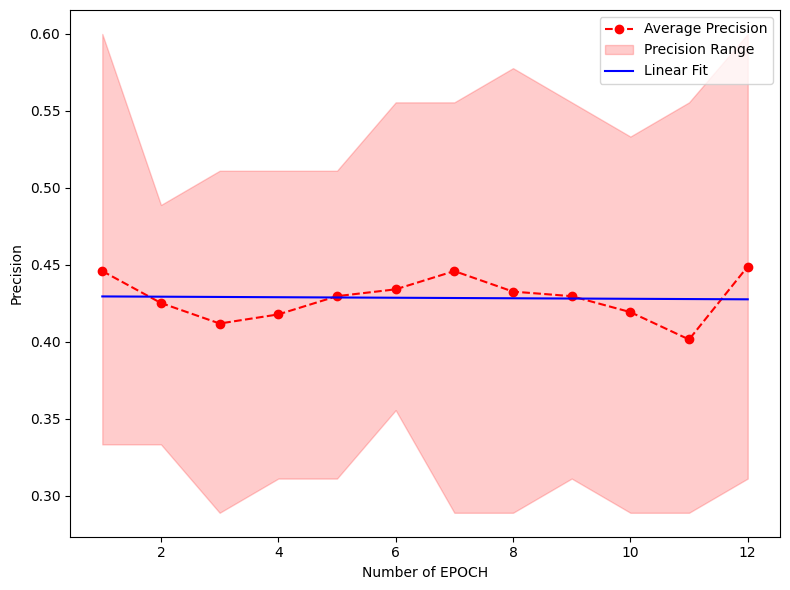

In [ ]:
n_epochs_tra_1=12

epoch_list = list(range(1, n_epochs_tra_1 + 1))
epoch_1_order= np.zeros(( len(networks),n_epochs_tra_1))
epoch_2_order= np.zeros((  len(networks),n_epochs_tra_1))
precision_high = np.zeros((  len(networks),n_epochs_tra_1))

for network in range( 0, 15):

  for epoch in range(n_epochs_tra_1):

    patterns_tensor = Array_Words(2, 45 )

    output_first_order = networks[network][0](patterns_tensor)
    output_second_order = networks[network][1]( patterns_tensor, output_first_order).squeeze()

    order_2_tensor = target_second(patterns_tensor , output_first_order)
    loss_2 = networks[network][3](   output_second_order  , order_2_tensor     ).requires_grad_()
    loss_2.backward(retain_graph=True)
    networks[network][5].step()
    networks[network][5].zero_grad()


    loss_1 = networks[network][2](   output_first_order  ,   patterns_tensor    ).requires_grad_()
    loss_1.backward(retain_graph=True)
    networks[network][4].step()
    networks[network][4].zero_grad()

    epoch_1_order[network][epoch] = loss_1.detach().item()
    epoch_2_order[network][epoch] = loss_2.detach().item()
    precision_high[network][epoch]= calculate_precision(patterns_tensor, output_first_order)

epoch_list_high=epoch_list
flattened_loss_1_high = [item for sublist in epoch_1_order for item in sublist]
flattened_precision_high = [item for sublist in precision_high for item in sublist]


start_network = 0
end_network = 15

avg_1_order = calculate_average(epoch_1_order, start_network, end_network)
max_1_order = calculate_max(epoch_1_order, start_network, end_network)
min_1_order = calculate_min(epoch_1_order, start_network, end_network)

avg_2_order = calculate_average(epoch_2_order, start_network, end_network)
max_2_order = calculate_max(epoch_2_order, start_network, end_network)
min_2_order = calculate_min(epoch_2_order, start_network, end_network)

avg_precision_high=calculate_average(precision_high, start_network, end_network)
max_precision_high=calculate_max(precision_high, start_network, end_network)
min_precision_high=calculate_min(precision_high, start_network, end_network)


# Set up the plot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figure size as needed

# First graph for 1st Order Network
ax1.plot(epoch_list, avg_1_order,  linestyle='--', marker='o', color='b' , label='Average Loss - 1st Order')
ax1.fill_between(epoch_list, min_1_order, max_1_order, color='b', alpha=0.2)
ax1.legend(['Average loss 1st Order Network - HIGH CONSCIOUSNESS'])
ax1.set_xlabel('Number of EPOCH')
ax1.set_ylabel('LOSS')
# Second graph for 2nd Order Network
ax2.plot(epoch_list, avg_2_order,  linestyle='--', marker='o', color='r' , label='Average Loss - 2nd Order')
ax2.fill_between(epoch_list, min_2_order, max_2_order, color='r', alpha=0.2)
ax2.legend(['Average loss 2nd Order Network - HIGH CONSCIOUSNESS'])
ax2.set_xlabel('Number of EPOCH')
ax2.set_ylabel('LOSS')

# Display the plots side by side
plt.tight_layout()
plt.show()


# PLOT PRECISION, Linear Regression
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figure size as needed
ax.plot(epoch_list, avg_precision_high, linestyle='--', marker='o', color='r', label='Average Precision')
ax.fill_between(epoch_list, min_precision_high, max_precision_high, color='r', alpha=0.2, label='Precision Range')
y_pred_linear = perform_linear_regression(epoch_list, avg_precision_high)
ax.plot(epoch_list, y_pred_linear, linestyle='-', color='b', label='Linear Fit')
ax.set_xlabel('Number of EPOCH')
ax.set_ylabel('Precision')
ax.legend()
plt.tight_layout()
plt.show()


# TRAINING - LOW CONSCIOUSNESS


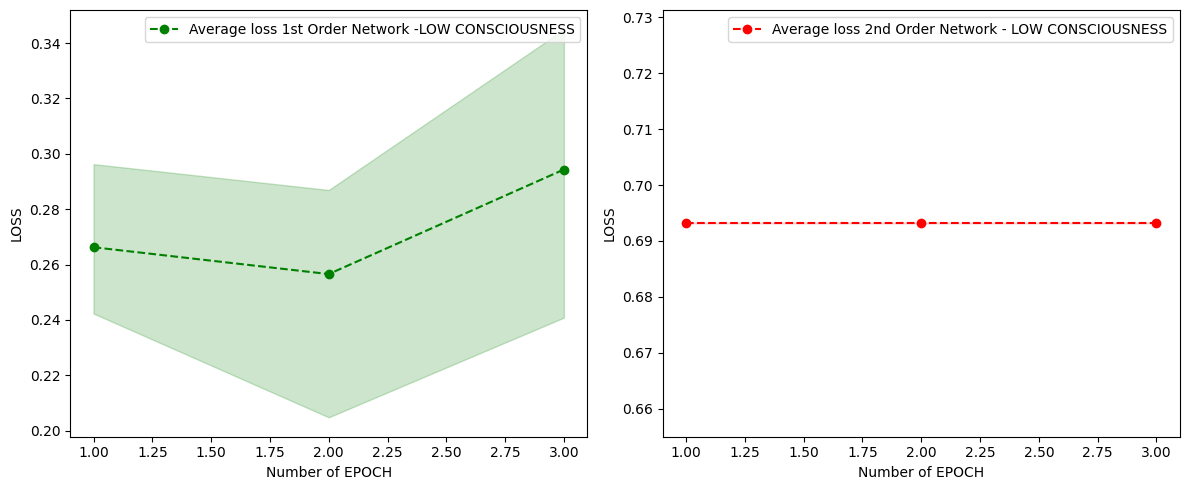

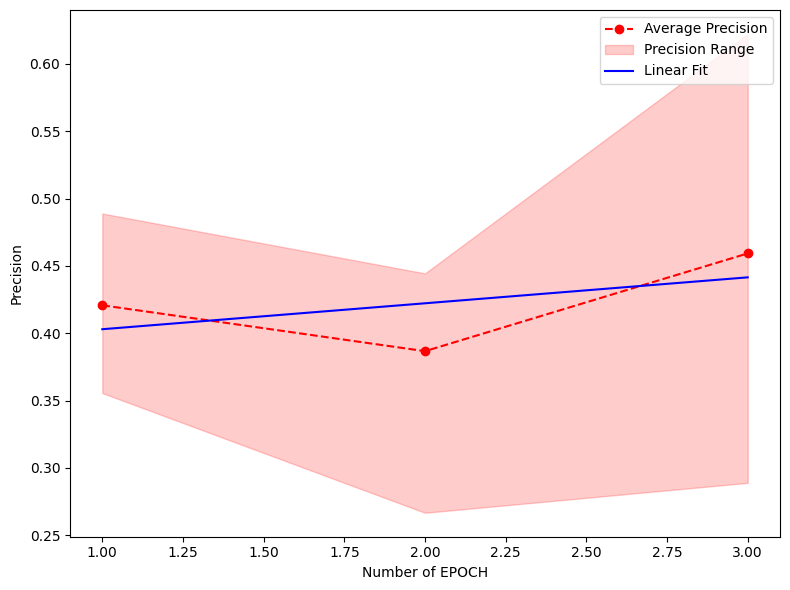

In [ ]:
n_epochs_tra_2= 3

epoch_list = list(range(1, n_epochs_tra_2 + 1))
epoch_1_order= np.zeros(( len(networks),n_epochs_tra_2))
epoch_2_order= np.zeros((  len(networks),n_epochs_tra_2))
precision_low = np.zeros((  len(networks),n_epochs_tra_2))


for network in range( 15, 30):

  for epoch in range(n_epochs_tra_2):

    patterns_tensor = Array_Words(2, 45 )

    output_first_order = networks[network][0](patterns_tensor)
    output_second_order = networks[network][1]( patterns_tensor, output_first_order).squeeze()

    order_2_tensor = target_second(patterns_tensor , output_first_order)
    loss_2 = networks[network][3](   output_second_order  , order_2_tensor     ).requires_grad_()
    loss_2.backward(retain_graph=True)
    networks[network][5].step()
    networks[network][5].zero_grad()


    loss_1 = networks[network][2](   output_first_order  ,   patterns_tensor    ).requires_grad_()
    loss_1.backward(retain_graph=True)
    networks[network][4].step()
    networks[network][4].zero_grad()

    epoch_1_order[network][epoch] = loss_1.detach().item()
    epoch_2_order[network][epoch] = loss_2.detach().item()

    precision_low[network][epoch]= calculate_precision(patterns_tensor, output_first_order)

epoch_list_low=epoch_list
flattened_loss_1_low = [item for sublist in epoch_1_order for item in sublist]
flattened_precision_low = [item for sublist in precision_low for item in sublist]

start_network = 15
end_network = 30

# Using the modified functions
avg_1_order = calculate_average(epoch_1_order, start_network, end_network)
max_1_order = calculate_max(epoch_1_order, start_network, end_network)
min_1_order = calculate_min(epoch_1_order, start_network, end_network)

avg_2_order = calculate_average(epoch_2_order, start_network, end_network)
max_2_order = calculate_max(epoch_2_order, start_network, end_network)
min_2_order = calculate_min(epoch_2_order, start_network, end_network)

avg_precision_low=calculate_average(precision_low, start_network, end_network)
max_precision_low=calculate_max(precision_low, start_network, end_network)
min_precision_low=calculate_min(precision_low, start_network, end_network)

# Set up the plot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figure size as needed

# First graph for 1st Order Network
ax1.plot(epoch_list, avg_1_order,  linestyle='--', marker='o', color='g' , label='Average Loss - 1st Order')
ax1.fill_between(epoch_list, min_1_order, max_1_order, color='g', alpha=0.2)
ax1.legend(['Average loss 1st Order Network -LOW CONSCIOUSNESS'])
ax1.set_xlabel('Number of EPOCH')
ax1.set_ylabel('LOSS')

# Second graph for 2nd Order Network
ax2.plot(epoch_list, avg_2_order,  linestyle='--', marker='o', color='r' , label='Average Loss - 2nd Order')
ax2.fill_between(epoch_list, min_2_order, max_2_order, color='r', alpha=0.2)
ax2.legend(['Average loss 2nd Order Network - LOW CONSCIOUSNESS'])
ax2.set_xlabel('Number of EPOCH')
ax2.set_ylabel('LOSS')

# Display the plots side by side
plt.tight_layout()
plt.show()



# PLOT PRECISION, Linear Regression
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figure size as needed
ax.plot(epoch_list, avg_precision_low, linestyle='--', marker='o', color='r', label='Average Precision')
ax.fill_between(epoch_list, min_precision_low, max_precision_low, color='r', alpha=0.2, label='Precision Range')
y_pred_linear = perform_linear_regression(epoch_list, avg_precision_low)
ax.plot(epoch_list, y_pred_linear, linestyle='-', color='b', label='Linear Fit')
ax.set_xlabel('Number of EPOCH')
ax.set_ylabel('Precision')
ax.legend()
plt.tight_layout()
plt.show()



#SCATTER PLOT - TRAINING PHASE

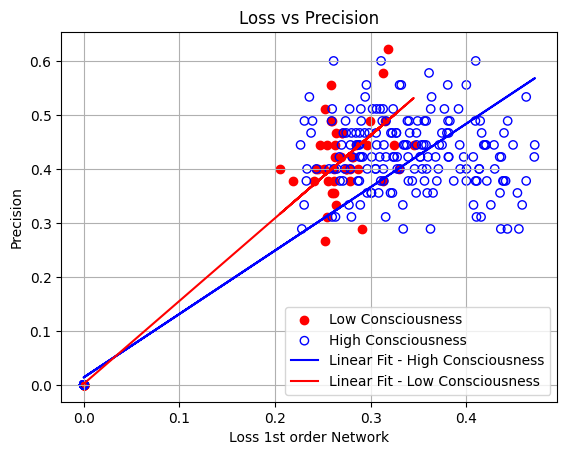

In [ ]:
plt.scatter(flattened_loss_1_low, flattened_precision_low, edgecolor='red', facecolors='red', label='Low Consciousness')
plt.scatter(flattened_loss_1_high, flattened_precision_high, edgecolor='blue', facecolors='none',
            marker='o', label='High Consciousness')

y_pred_linear = perform_linear_regression(flattened_loss_1_high, flattened_precision_high)
plt.plot(flattened_loss_1_high, y_pred_linear, linestyle='-', color='b', label='Linear Fit - High Consciousness')

y_pred_linear = perform_linear_regression(flattened_loss_1_low, flattened_precision_low)
plt.plot(flattened_loss_1_low, y_pred_linear, linestyle='-', color='r', label='Linear Fit - Low Consciousness')

# Setting the axis labels and title
plt.xlabel('Loss 1st order Network')
plt.ylabel('Precision')
plt.title('Loss vs Precision')
plt.grid(True)

# Adding a legend to the plot
plt.legend()

# Showing the plot
plt.show()

# MODEL LOADING AND PREPARISSON FOR EVALUATION

In [ ]:
Testing_grammar_A= Array_Words(2, 30 )
Testing_grammar_B= Array_Words(3, 30 )

Testing_patterns= np.concatenate((Testing_grammar_A, Testing_grammar_B))
Testing_patterns= torch.Tensor(Testing_patterns).to(device)

for network in range(len(networks)):
  networks[network][0].eval()
  networks[network][1].eval()


# TESTING LOOP

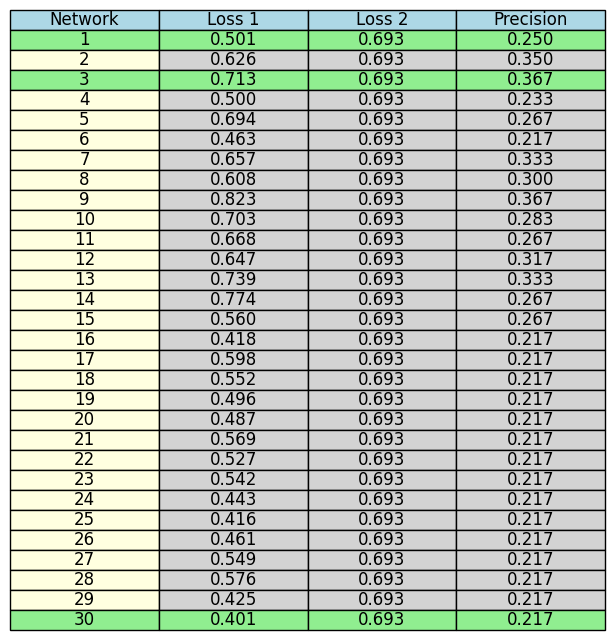

In [ ]:
numbers_networks = list(range(1, 31))
loss_1_networks= np.zeros(30)
loss_2_networks= np.zeros(30)
precision_networks= np.zeros(30)


for network in range(len(networks)):


  with torch.no_grad():

    patterns_tensor= Testing_patterns
    output_first_order = networks[network][0](patterns_tensor)

    output_second_order = networks[network][1]( patterns_tensor , output_first_order ).squeeze()

    order_2_tensor = target_second(patterns_tensor , output_first_order)

    loss_1 = networks[network][2](   output_first_order  ,   patterns_tensor    ).requires_grad_()
    loss_2 = networks[network][3](   output_second_order  , order_2_tensor     ).requires_grad_()


    loss_1_networks[network] = loss_1
    loss_2_networks[network] = loss_2

    precision_networks[network]=  calculate_precision(patterns_tensor, output_first_order)


# Find the index of the lowest precision value
max_precision_index = np.argmax(precision_networks)
min_loss_1_index = np.argmin(loss_1_networks)
min_loss_2_index = np.argmin(loss_2_networks)

# Set up the plot
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table_data = []

# Add header row with different background color
header_row = ['Network', 'Loss 1', 'Loss 2', 'Precision']
cell_colors = ['lightyellow', 'lightgray', 'lightgray', 'lightgray']
table_data.append(header_row)

for i, (number, loss_1, loss_2, precision_value) in enumerate(zip(numbers_networks, loss_1_networks, loss_2_networks, precision_networks)):
    row_data = [number, f'{loss_1:.3f}', f'{loss_2:.3f}', f'{precision_value:.3f}']
    table_data.append(row_data)

# Create the table object
table = ax.table(cellText=table_data, colLabels=None, cellLoc='center', loc='center', cellColours=[cell_colors]*len(table_data))

# Set background color for title cells
for i, title in enumerate(header_row):
    table[0, i].set_facecolor('lightblue')

for i, title in enumerate(header_row):
    table[max_precision_index + 1, i].set_facecolor('lightgreen')

for i, title in enumerate(header_row):
    table[min_loss_1_index + 1, i].set_facecolor('lightgreen')

for i, title in enumerate(header_row):
    table[min_loss_2_index + 1, i].set_facecolor('lightgreen')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
plt.show()

#SCATTER PLOT - TESTING PHASE

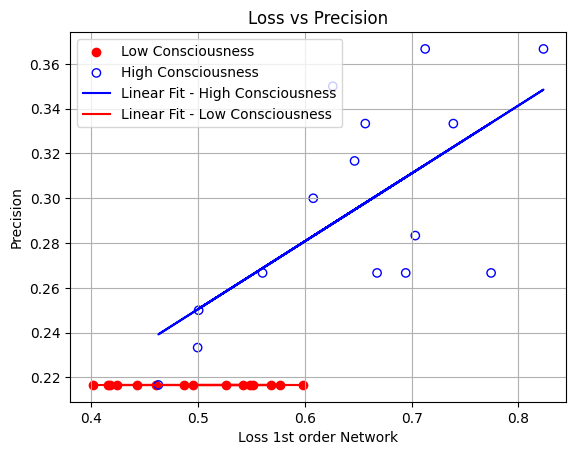

In [ ]:
split_index = len(precision_networks) // 2

flattened_precision_high = precision_networks[:split_index]
flattened_precision_low = precision_networks[split_index:]
flattened_loss_1_high = loss_1_networks[:split_index]
flattened_loss_1_low = loss_1_networks[split_index:]


plt.scatter(flattened_loss_1_low, flattened_precision_low, edgecolor='red', facecolors='red', label='Low Consciousness')
plt.scatter(flattened_loss_1_high, flattened_precision_high, edgecolor='blue', facecolors='none',
            marker='o', label='High Consciousness')

y_pred_linear = perform_linear_regression(flattened_loss_1_high, flattened_precision_high)
plt.plot(flattened_loss_1_high, y_pred_linear, linestyle='-', color='b', label='Linear Fit - High Consciousness')

y_pred_linear = perform_linear_regression(flattened_loss_1_low, flattened_precision_low)
plt.plot(flattened_loss_1_low, y_pred_linear, linestyle='-', color='r', label='Linear Fit - Low Consciousness')

# Setting the axis labels and title
plt.xlabel('Loss 1st order Network')
plt.ylabel('Precision')
plt.title('Loss vs Precision')
plt.grid(True)

# Adding a legend to the plot
plt.legend()

# Showing the plot
plt.show()